In [40]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
from array import array
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat
import pandas as pd

In [41]:
outstr = 'timeuniformity_C3'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/04_09_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [42]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
#reader = csv.reader(open('data/energyscans19C_3x3.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if 'C3' in crystal:
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')        

energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]
round_energies = [round(float(energy),-1) for energy in energies]
if round_energies[-1] ==240 : round_energies[-1] = 250.

In [61]:
dict_df_energy = {}

for energy in energies:
#for energy in [energies[-1]]:
    
    runs = dict_C3_energy_scan[energy]
    tree = ROOT.TChain("h4")
    for run in runs:
        tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
    pos_cut = 4
    data = []
    for evt in tree:
        ############CHange e3x3 cut per energy!!!!!########
       # if evt.n_tracks==1 and evt.e3x3<10000. and evt.e3x3>8300. and evt.X[0] > -9. and evt.X[0] < 1. and evt.Y[0]>-1. and evt.Y[0]<8. : 
        if evt.n_tracks==1 and evt.X[0] > -9. and evt.X[0] < 1. and evt.Y[0]>-1. and evt.Y[0]<8. : 

            evt_dict = {}
            e = round(float(evt.Energy),-1)
            if e ==240 : e = 250.
            evt_dict['Energy'] = e
            evt_dict['e3x3'] = evt.e3x3
            evt_dict['seed'] = evt.seed
            evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]/evt.b_rms[evt.MCP1]
            evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]/evt.b_rms[evt.MCP2]
            evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
            evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
            for xstal in matrix_3:
                evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
                evt_dict['amp_max_'+xstal] = evt.amp_max[getattr(evt, xstal)]
                evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
                evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
                evt_dict['fit_terr_'+xstal] = evt.fit_terr[getattr(evt, xstal)]
                evt_dict['%s'%xstal] = getattr(evt,xstal)
            data.append(evt_dict)

    df = pd.DataFrame(data) 
    dict_df_energy[energy] = df

    pd_name = '%s/ECAL_H4_October2018_pandas_C3beamscan_full2_%s.csv'%(trees_path,int(e))
   # pd_name = '%s/ECAL_H4_October2018_pandas_C3_3x3_%s.csv'%(trees_path,int(e))
    df.to_csv(pd_name)

Error in <TFile::TFile>: file /eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_13550.root does not exist
Error in <TFile::TFile>: file /eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_13551.root does not exist
Error in <TFile::TFile>: file /eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_13552.root does not exist
Error in <TFile::TFile>: file /eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_13553.root does not exist


In [43]:
### Only used when I dont want to rerun the dataframe creation (takes longer than read csv file)
dict_df_energy = {}
for energy in round_energies:
#for energy in energies:
    pd_name = '%s/ECAL_H4_October2018_pandas_C3beamscan_full_%s.csv'%(trees_path,int(energy))
    print pd_name
    df = pd.read_csv(pd_name)    
    dict_df_energy[energy] = df

/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full_50.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full_100.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full_150.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full_200.csv
/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7//ECAL_H4_October2018_pandas_C3beamscan_full_250.csv


<Figure size 432x288 with 0 Axes>

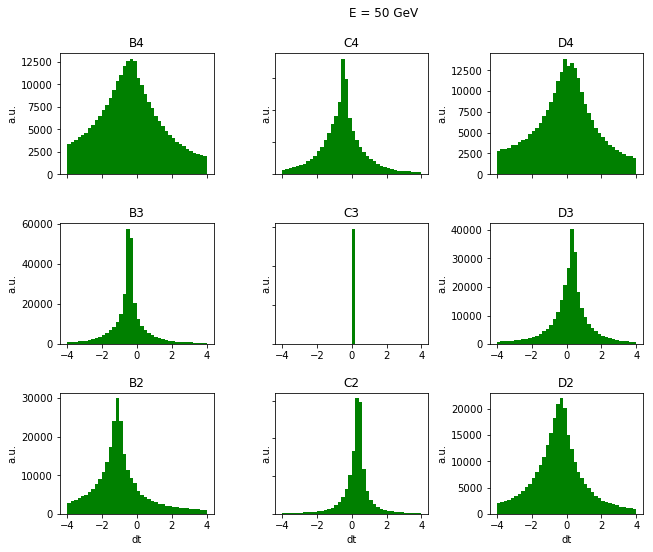

<Figure size 432x288 with 0 Axes>

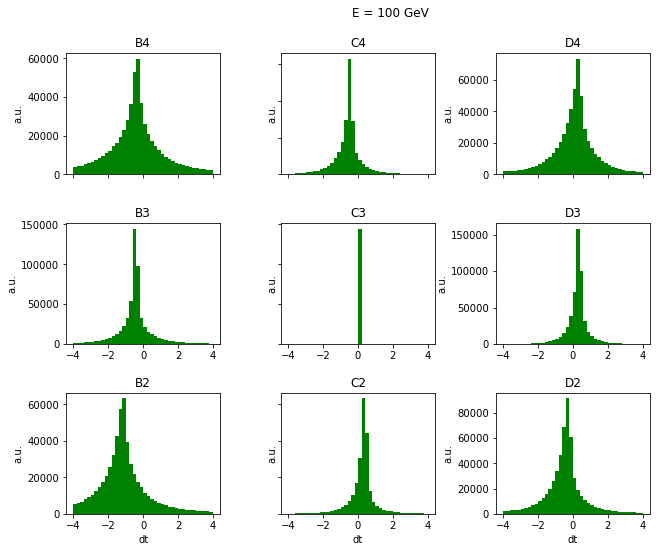

<Figure size 432x288 with 0 Axes>

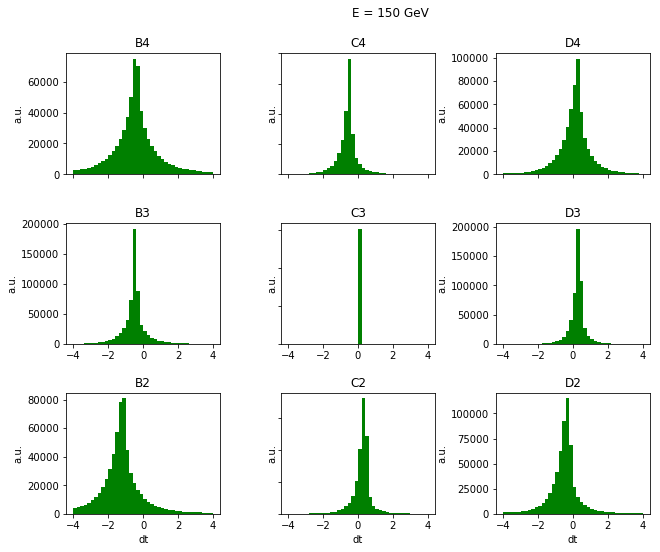

<Figure size 432x288 with 0 Axes>

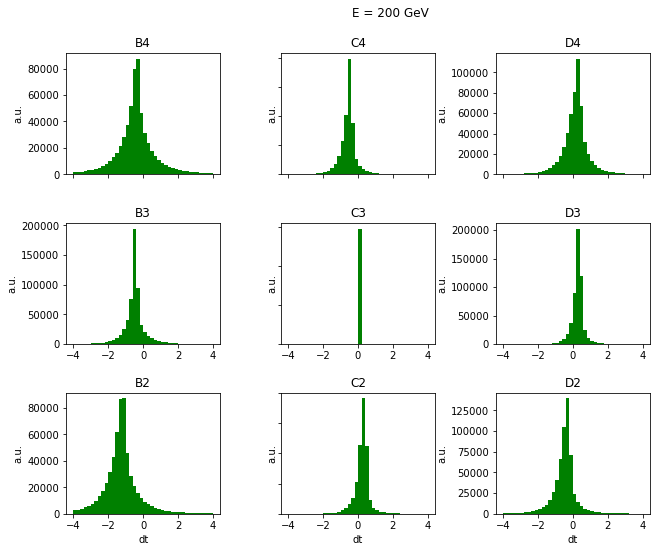

<Figure size 432x288 with 0 Axes>

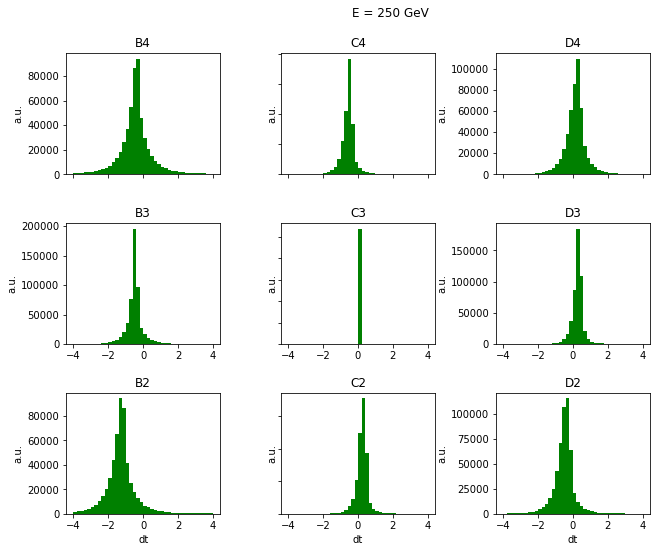

In [65]:
for num,energy in enumerate(energies):
    df = dict_df_energy[energy] 
    plt.clf()
    f, axarr = plt.subplots(3, 3)
    f.suptitle('E = %d GeV'%round_energies[num])
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    for i in range(0,3):
        for j in range(0,3):
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            m = np.array(matrix_3).reshape(3,3)
            crystal = m[i,j]
            dt = df['fit_time_C3']-df['fit_time_%s'%crystal]
            dt = dt-(dt/6.25).astype('int32')*6.25
            axarr[i, j].hist(list(dt),range=[-4,4],bins=40,color='g')
            axarr[i, j].set_title(crystal)
            if i==2 : axarr[i, j].set_xlabel('dt')
            axarr[i, j].set_ylabel('a.u.')
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    f.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    figname = '%s/dt_C3_crystal_%d_%s'%(plot_folder,round_energies[num],outstr)
    f.savefig(figname+'.png')
    f.savefig(figname+'.pdf')

## Per each event we want to calculate x and y of where the electron beam had it's impact

In [64]:
#crystal = 'C3'
#conditions = [
#    (df['fit_ampl_%s'%crystal] > 0 ),
#    (df['fit_ampl_%s'%crystal] <= 0)]
#choices = [df['fit_ampl_%s'%crystal], df['amp_max_%s'%crystal]]
#df['final_ampl_%s'%crystal] = np.select(conditions, choices)      
        

In [5]:
from math import log

intercalibration_file = '/eos/user/n/nchernya/SWAN_projects/ECALtestBeam/output/01_08_2019_v7/conversion_factor_v7.json'
with open('%s'%(intercalibration_file), 'r') as fp:
    dict_crystals_calibration = json.load(fp)

for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    df['sum_3x3']=0.
    for crystal in matrix_3:
        df['sum_3x3'] += df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]

In [6]:
## loose selection
energy_selection = [[1500,2000],[2500,4000],[4000,5900],[5000,7900],[7000,9800]]
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    df = df.loc[(df['sum_3x3']<energy_selection[num][1]) & (df['sum_3x3']>energy_selection[num][0])]

#ranges = [[1500,2500],[2000,4500],[4000,6500],[5000,9000],[7000,10000]]
#for n,energy in enumerate(energies):
#    df = dict_df_energy[energy]
#    plt.yscale('log')
#    _,_,_ = plt.hist(df['sum_3x3'],bins=100,range=ranges[n])
#    plt.show()

In [7]:
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    
    df['pos_sum_w']=0.
    df['ecal_x']=0.
    df['ecal_y']=0.

    for i in range(0,3):
        for j in range(0,3):
            m = np.array(matrix_3).reshape(3,3)
            crystal = m[i,j]    
            w = 4.2 +  np.log(df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]/df['sum_3x3'])
            w[w < 0] = 0
            df['ecal_x'] += ((j+1)*22-11-33)*w
            df['ecal_y'] += ((i+1)*22-11-33)*w  #center of C3 
            df['pos_sum_w'] += w
    
    df['ecal_x']/=df['pos_sum_w']
    df['ecal_y']/=df['pos_sum_w']
    df['ecal_r'] = np.sqrt(df['ecal_x']*df['ecal_x'] + df['ecal_y']*df['ecal_y'])

/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: divide by zero encountered in log
/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: invalid value encountered in log


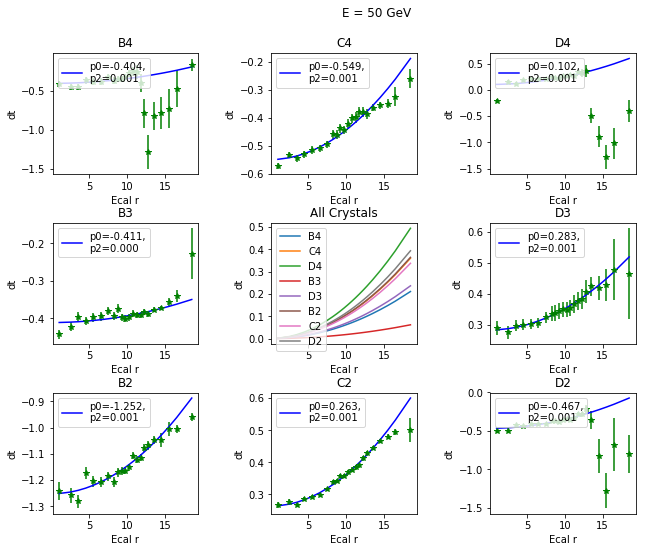

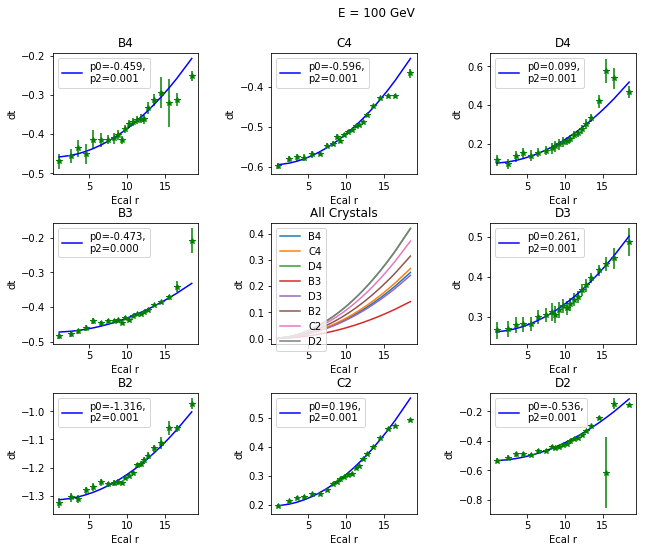

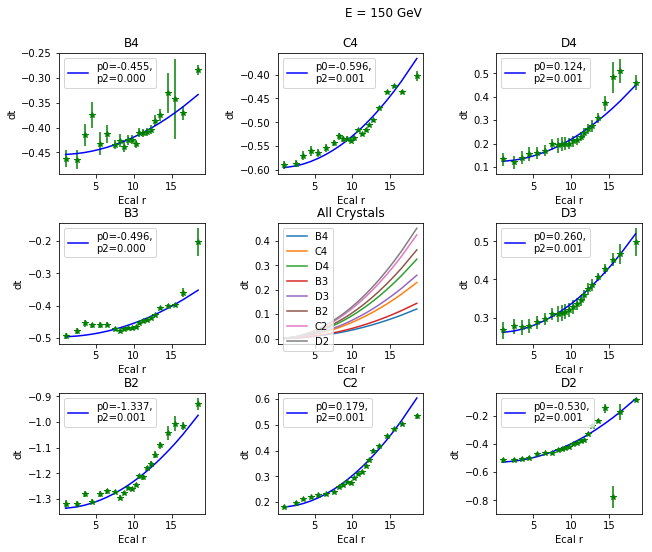

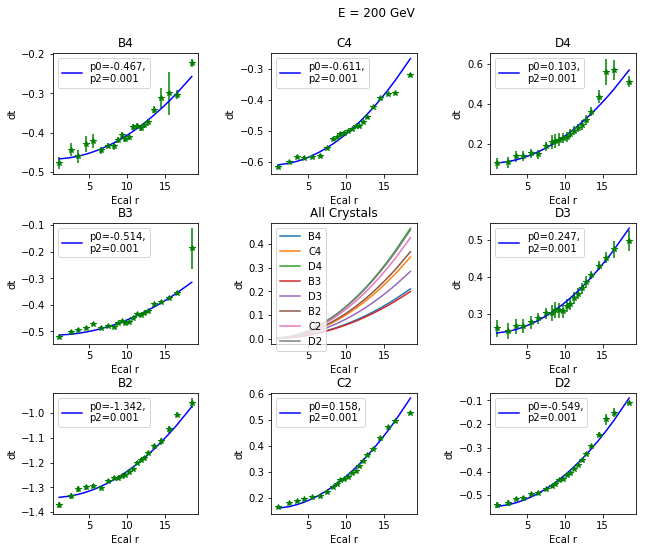

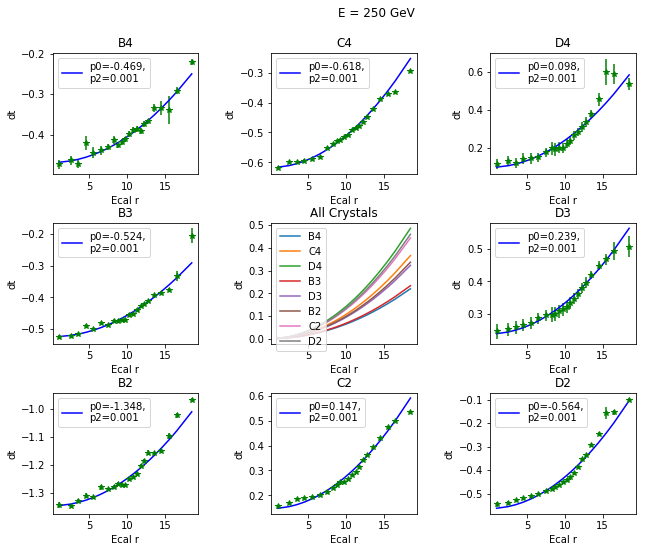

In [30]:
import seaborn as sns
from scipy.stats import crystalball
from math import sqrt
from scipy import optimize


def parabola(x, p1, p2, p3):
    return p1 + p2*x + p3*x*x

def parabola_fixed(x, p1, p3):
    return p1 + p3*x*x

dict_dt_fit = {}

what_to_plot = ['dt','res']
what_idx = 0

for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 

    dict_dt_fit[int(energy)] = {}

    f, axarr = plt.subplots(3, 3)
    DefaultSize = f.get_size_inches()
    f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    f.suptitle('E = %d GeV'%round_energies[num])
    
    # dr_samples = np.linspace(0, 20.0, num=10)
    dr_samples = [0,2,3,4,5,6,7,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,14,15,16,17,20]
    crystals_times_data = []

    for i in range(0,3):
        for j in range(0,3):
            plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
            m = np.array(matrix_3).reshape(3,3)
            crystal = m[i,j]
            dt = df['fit_time_C3']-df['fit_time_%s'%crystal]
            df['dt_C3_%s'%crystal] = dt - ((dt/6.25).astype('int32')*6.25)
            
            distance = 18

            if (j-1)==0 :
                subdf = df[(df['ecal_x'] < distance) & (df['ecal_x'] > -distance) & (df['ecal_y']*np.sign(i-1) > 0 ) & ((df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']))] #& (df['seed']==df['%s'%crystal])
            elif (i-1)==0 :
                subdf = df[(df['ecal_y'] < distance) & (df['ecal_y'] > -distance) & (df['ecal_x']*np.sign(j-1) > 0 ) & ((df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']))]
            else : 
                subdf = df[(df['ecal_y']*np.sign(i-1) > 0) & (df['ecal_x']*np.sign(j-1) > 0 )& ((df['seed']==df['%s'%crystal]) | (df['seed']==df['C3'])) ]
         #   subdf = df[(df['seed']==df['%s'%crystal]) | (df['seed']==df['C3']) ]

                ### plus add condition on seed = crystal
            
        
           # sns.regplot(x=subdf['ecal_r'], y=subdf['dt_C3_%s'%crystal], x_bins=20, fit_reg=None,ax=axarr[i, j]) 
            delta_ts_cb_mean = []
            delta_ts_cb_mean_err = []
            delta_ts_cb_std = []
            delta_ts_cb_std_err = []
            dr_samples_bins = []        
        
            for num_dr in range(0,len(dr_samples)-1):
                dr_samples_bins.append(dr_samples[num_dr]+(dr_samples[num_dr+1]-dr_samples[num_dr])/2.)
                subdf_r = subdf.loc[(df['ecal_r']<dr_samples[num_dr+1]) & (df['ecal_r']>dr_samples[num_dr])]
                serie = subdf_r['dt_C3_%s'%crystal]
        #        delta_ts_cb_mean.append(serie.mean())
                if crystal=='C3':
                    loc = 0.
                    scale = 0.
                else :  
                    beta, cb_m, loc, scale = crystalball.fit(serie,loc=serie.median(),scale=serie.std())
                    delta_ts_cb_mean_err.append(serie.std()/sqrt(serie.shape[0]))
                delta_ts_cb_mean.append(loc)
                delta_ts_cb_std.append(scale)
        

            if crystal!='C3': 
                if what_to_plot[what_idx] == 'dt' :
                    axarr[i, j].errorbar(dr_samples_bins, delta_ts_cb_mean, yerr=delta_ts_cb_mean_err, marker='*', linestyle='',color='g')
                   # params, params_covariance = optimize.curve_fit(parabola, np.array(dr_samples_bins)[np.array(dr_samples_bins)<15], np.array(delta_ts_cb_mean)[np.array(dr_samples_bins)<15],absolute_sigma=True, sigma=np.array(delta_ts_cb_mean_err)[np.array(dr_samples_bins)<15])
                   # axarr[i, j].plot(dr_samples_bins, parabola(np.array(dr_samples_bins), params[0], params[1],params[2]),color='r',label = 'p0=%.3f,\np1=%.3f,\np2=%.3f'%(params[0], params[1],params[2]))
                
                    params2, params_covariance2 = optimize.curve_fit(parabola_fixed, np.array(dr_samples_bins)[np.array(dr_samples_bins)<15], np.array(delta_ts_cb_mean)[np.array(dr_samples_bins)<15],absolute_sigma=True, sigma=np.array(delta_ts_cb_mean_err)[np.array(dr_samples_bins)<15])
                    axarr[i, j].plot(dr_samples_bins, parabola_fixed(np.array(dr_samples_bins), params2[0], params2[1]),color='b',label = 'p0=%.3f,\np2=%.3f'%(params2[0], params2[1]))
                
                    dict_dt_fit[int(energy)]['%s'%crystal] = {'p0':params2[0],'p2':params2[1]}
                    
                    #crystals_times_data.append([(item-params2[0]) for item in delta_ts_cb_mean])
                    crystals_times_data.append([(parabola_fixed(item, params2[0], params2[1])- params2[0]) for item in dr_samples_bins])
                    #crystals_times_data.append([(parabola(item, params[0], params[1],params[2])- params[0]) for item in dr_samples_bins])
    
                else : axarr[i, j].plot(dr_samples_bins, delta_ts_cb_std, marker='*', linestyle='',color='g')

                
            axarr[i, j].set_title(crystal)
            axarr[i, j].set_xlabel('Ecal r')
            if what_to_plot[what_idx] == 'dt' : axarr[i, j].set_ylabel('dt')
            else : axarr[i, j].set_ylabel('time resolution')
            axarr[i, j].legend(loc='upper left')
        
    axarr[1, 1].set_title('All Crystals')        
    out = axarr[1, 1].plot(np.array(dr_samples_bins), np.array(crystals_times_data).transpose())
    axarr[1, 1].legend(iter(out),np.array(list(filter(lambda x: x!= 'C3', matrix_3))),loc='upper left')
        
    f.subplots_adjust(wspace=0.5, hspace=0.4)
    plt.show()
    if what_to_plot[what_idx] == 'dt' : 
        figname = '%s/dt_r_crystal_18_energy%d_%s'%(plot_folder,energy,outstr)
        with open('%s/dt_fit_parabola_energy%d_%s.json'%(output_folder,energy,outstr), 'w') as fp:
            json.dump(dict_dt_fit, fp)
    else :  
        figname = '%s/timeres_r_crystal_18_energy%d_%s'%(plot_folder,energy,outstr)
    
    f.savefig(figname+'.png')
    f.savefig(figname+'.pdf')

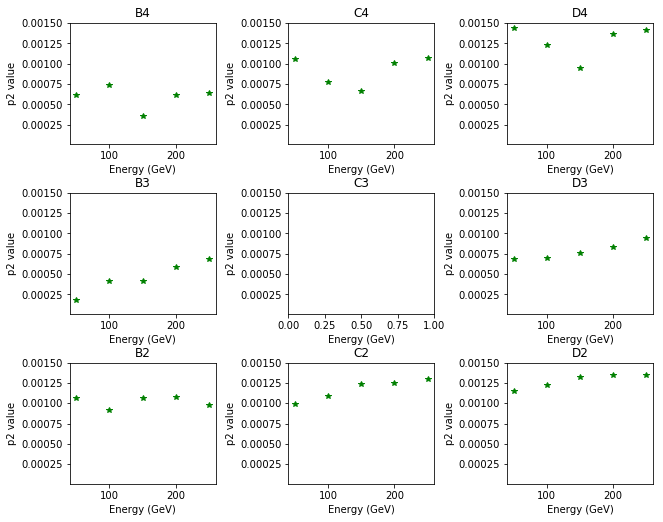

In [49]:
f, axarr = plt.subplots(3, 3)
DefaultSize = f.get_size_inches()
f.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
    
for i in range(0,3):
    for j in range(0,3):
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        m = np.array(matrix_3).reshape(3,3)
        crystal = m[i,j]
        
        if crystal!='C3': 
            axarr[i, j].plot(round_energies,map(lambda x: dict_dt_fit[x][crystal]['p2'],  round_energies) , marker='*', linestyle='',color='g')
        axarr[i, j].set_ylim([0.00001,0.0015]) 
        axarr[i, j].set_title(crystal)
        axarr[i, j].set_ylabel('p2 value')
        axarr[i, j].set_xlabel('Energy (GeV)')
        #axarr[i, j].legend(loc='upper left')

f.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()
figname = '%s/dt_r_fitparams_crystal_energy%d_%s'%(plot_folder,energy,outstr)
f.savefig(figname+'.png')
f.savefig(figname+'.pdf')

In [58]:
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 

    for crystal in list(filter(lambda x: x!= 'C3', matrix_3)):
        df['fit_time_%s_subtracted'%crystal] = df['fit_time_%s'%crystal] - parabola_fixed(np.array(df['ecal_r']), dict_dt_fit[energy][crystal]['p0'], dict_dt_fit[energy][crystal]['p2'])

In [146]:
def time_res_crystal(x, n= 1.07332e+04  ,c = 20.):
    return np.sqrt(n*n/(x*x) + c*c)

for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)] 
    df['sum_time_crystals']=0.
    df['sum_inv_res']=0.
    for crystal in ['C3']:
        resolution = time_res_crystal((df['fit_ampl_%s'%crystal]*dict_crystals_calibration[crystal]/df['noise_C3']).values)
        df['sum_inv_res']+=1./resolution
        if crystal!='C3' :
            df['sum_time_crystals'] += df['fit_time_%s_subtracted'%crystal]/resolution
        else : 
            df['sum_time_crystals'] += df['fit_time_%s'%crystal]/resolution
    df['sum_time_crystals']/=df['sum_inv_res']

/usr/local/bin/start_ipykernel.py:2: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


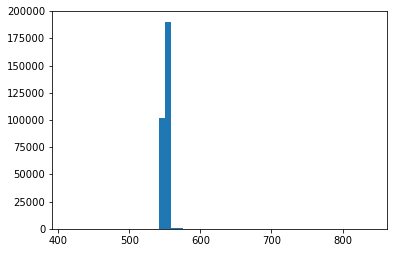

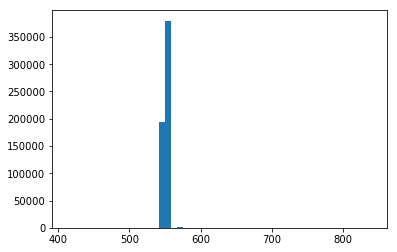

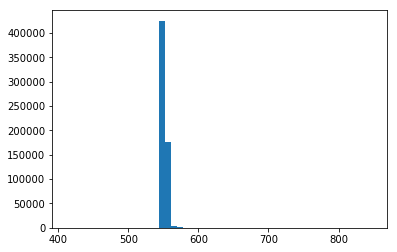

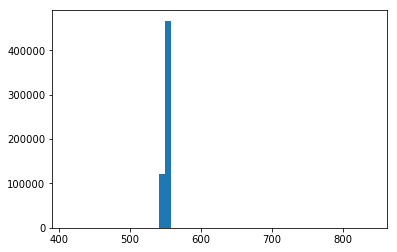

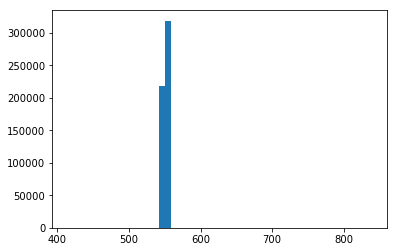

In [147]:
for num,energy in enumerate(round_energies):
    df = dict_df_energy[int(energy)]

    #subdf = df.loc[(df['sum_time_crystals']>500) & (df['sum_time_crystals']<600) & (df['seed'] == df['C3'])]
    
    #beta, cb_m, loc, scale = crystalball.fit(subdf['sum_time_crystals'],loc=subdf['sum_time_crystals'].median(),scale=subdf['sum_time_crystals'].std())
    n,bins,_ = plt.hist(df['fit_time_C3'],bins=50)
    #y = crystalball.pdf( bins, beta, cb_m, loc, scale)
    #l = plt.plot(bins, y, 'g--', linewidth=2)
    plt.show()